<div class="usecase-title">Melbourne Bicycle Network Routes and Road Safety: Part 2</div>

<div class="usecase-authors"><b>Authored by: </b> Anugra Sara Thomas and Bree McLennan</div>

<div class="usecase-duration"><b>Duration:</b> 120 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data engineering and analysis</div>
</div>

<div class="usecase-section-header">Scenario</div>

**1. As a cyclist, I want a safe transport journey in the city of Melbourne. Which roads are safest to cycle on?** 

From a cyclist road users' perspective, I want a safe transport journey in Melbourne. 
I seek to understand which sections of bicycle road network are the safest and which have the highest occurrence of accidents
so that I can use this insight to plan the safest possible journey.

**2. As a council, we seek to invest in road safety initiatives which reduce the occurrences of accidents resulting in serious injuries of citizens using our road network. Where are accident hotspots for cyclists occurring?**

From a leadership & strategic perspective, as a council, we seek to invest in road safety initiatives which can effectively reduce the occurrences of accidents resulting in serious injuries and fatalities of citizens using our road network. 

Where are accident hot spots for cyclists (and other road users) occurring?

Are our current approaches to road and bicycle network design working and having the impact we expected?

<div class="usecase-section-header">Objectives for the Exploratory Data Analysis</div>

Using the power of data aggregation, we can combine Melbourne Open datasets such as transport networks and events
With open government datasets including traffic accident ‘crash stats’ from Victoria Police and traffic event data from VicRoads and begin to observe, analyze and report on geographical patterns between these datasets.

We can ask questions such as:

1. Are accidents which involve cyclists occurring on designated bicycle network paths or on different roads? Where, specifically?
2. What are the traffic accident circumstances? Are cyclists colliding with open car doors an increasing or decreasing problem?
3. Do accidents co-occur with road-works, weather events or other disruptive events?

Goals for exploratory data analysis:

1. Analyse the frequency, timing and characteristics of traffic accidents involving cyclists in Melbourne
2. Analyse the geographical location of these accidents and compare to the locations of the bicycle path network
3. Report on sections of roadway where higher accident rates are observed


<div class="usecase-section-header">Strategic benefits for City of Melbourne</div>

This use case and exploratory data analysis project can support the City of Melbourne in the following ways:

1. Support for the ‘Safety and Well-being’ strategic vision and goals

2. Influence the creation of a ‘key risk indicator’ to monitor progress on the reduction of the 'Number of transport-related injuries and fatalities’ on Melbourne roads

3. Support further discussion between City of Melbourne and Victorian Road Safety partner agencies to improve road network design and infrastructure programs

<div class="usecase-section-header">Background on Related Road Safety Initiatives in Victoria</div>

The approach to aggregating key data sources and analysing geographical attributes is currently used by the TAC (Transport Accident Commission) in Victoria when analysing accident hot-spots and reviewing whether the design of the road could be improved to reduce road trauma. 
    
This type of analysis was used by TAC in recent years to assess fatal accident hotspots in Geelong.

The TAC in partnership with the Victorian Road Safety partnering agencies discovered a cluster of fatal accidents occurring over a 5-year period along a specific stretch of road at Thompsons Road, North Geelong.
    
The analysis informed a strategic decision for road safety partners (Victoria Police, VicRoads, City of Greater Geelong, TAC) to re-design the road to make it safer.
    
The road re-design has resulted in a substantial reduction in road trauma along Thompsons Road in North Geelong.

A similar analysis technique and approach could be applied to the City of Melbourne road network


**REFERENCE:**

[1] https://regionalroads.vic.gov.au/map/barwon-south-west-improvements/thompson-road-safety-improvements


<div class="usecase-section-header">Goals for Part 2 of the Melbourne Bicycle Network and Road Safety EDA</div>

Using the results obtained from Part 1 of this analysis, Part 2 will aim to inspect in more detail:

1. The timing of bicycle accidents

2. The geography of bicycle accidents

3. The circumstances of the accident event


**Key reference material for this analysis:**

[1] https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html



<div class="usecase-section-header">Setting Up for Analysis</div>

To begin the analysis we first import the necessary libraries to support our exploratory data analysis using Melbourne Open data.

The following are core packages required for this exercise:

- json // Assists with parsing JSON (JavaScript Object Notation) from strings or files.
- folium // Assists with visualising data that's been manipulated in Python on an interactive leaflet map.
- seaborn // Assists with visualization of data. It provides a high-level interface for drawing attractive and informative statistical graphics.


In [ ]:
#Use google drive as the data repository
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install sodapy
!pip install mplleaflet
!pip install geopandas
!pip install pysal
!pip install cartoframes
!pip install contextily
!pip install pyyaml==5.4.1
!pip install gmaps
!jupyter nbextension enable --py gmaps

In [ ]:
###################################################################
# Libraries used for this use case and exploratory data analysis
###################################################################
import os
import time
import sys
import warnings
sys.path.insert(1,'/content/drive/My Drive/Uni Assignments/SIT782 Team Project B/data/') # so that we can import d2i_tools from the parent folder.
from d2i_tools2 import *
warnings.simplefilter("ignore")
from datetime import datetime, date
import numpy as np
import pandas as pd
from sodapy import Socrata
import json
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
import pysal
import contextily
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from pointpats import centrography

To connect to the Melbourne Open Data Portal we must establish a connection using the sodapy library by specifying a domain, being the website domain where the data is hosted, and an application access token which can be requested from the City of Melbourne Open Data portal by registering __[here](https://data.melbourne.vic.gov.au/signup)__

For this exercise we will access the domain without an application token.

In [ ]:
########################################################
# Accessing the Melbourne City Bicycle Network Dataset
########################################################

# Hyperlink to the dataset: https://data.melbourne.vic.gov.au/Transport/Bicycle-Network/24aw-nd3i
dataset_id = '24aw-nd3i' #Melbourne city Bicycle Network dataset

apptoken = os.environ.get("SODAPY_APPTOKEN") # Anonymous app token
domain = "data.melbourne.vic.gov.au"
client = Socrata(domain, apptoken) # Open Dataset connection

<div class="usecase-section-header">Exploring the Melbourne Bicycle Network Dataset</div>

Next, we will look at the **Bicycle-Network** dataset, to better understand its structure and how we can use it.

Our data requirements from this use case include the following:
- Visualising the bicycle network to learn where the bicycle paths are located

For this exercise, we start by examining the **Bicycle-Network** dataset.
Each dataset in the Melbourne Open Data Portal has a unique identifier which can be used to retrieve the dataset using the sodapy library.

The **Bicycle-Network** dataset unique identifier is **'24aw-nd3i'**.
We will pass this identifier into the sodapy command below to retrieve this data.

This dataset is placed in a Pandas dataframe and we will inspect the metadata.

In [ ]:
metadata_df = getMeta(apptoken)
print('Selected metadata for the dataset of interest')
metadata_df[metadata_df.id.isin([dataset_id])].T

**Working with the Melbourne Bicycle Network Routes Dataset as a geoJSON file**

The code below describes how to access the **Bicycle Network** dataset as a geoJSON file through the SOCRATA API. 

In [ ]:
# Dataset Source hyperlink: 
# https://data.melbourne.vic.gov.au/Transport/Bicycle-routes-including-informal-on-road-and-off-/24aw-nd3i
from urllib.request import urlopen
import json

geoJSON_Id = '24aw-nd3i' # Bicycle routes, including informal, on-road and off-road routes

#Call the API
GeoJSONURL = 'https://'+domain+'/api/geospatial/'+geoJSON_Id+'?method=export&format=GeoJSON'
with urlopen(GeoJSONURL) as response:
    bicyclepath = json.load(response)

#test the response and observe the high level geoJSON file structure
bicyclepath["features"][0]['properties'].keys()

<div class="usecase-section-header">Exploring the Traffic Accident 'Crash-Stats' Dataset</div>

This section focuses on setting up the Traffic Accident 'Crash-Stats' dataset and preparing it for use in the exploratory data analysis alongside the Melbourne Bicycle Network dataset.

**Setting up the Working Accident 'Crash-Stats' Dataset**

The working dataset will have the following structure.

In [ ]:
#dataset = pd.read_csv('interactive_dependencies/Accidents_Bicyclists_Melbourne_2017to2020.csv', parse_dates=['DATAccidentDate_accident'])
dataset= pd.read_csv('/content/drive/My Drive/Uni Assignments/SIT782 Team Project B/data/Accidents_Bicyclists_Melbourne_2017to2020.csv',parse_dates=['DATAccidentDate_accident'])
wrk_accident_bicyclists = dataset.copy()

In [ ]:
wrk_accident_bicyclists['NUMDayOfWeek'] = wrk_accident_bicyclists['DATAccidentDate_accident'].dt.strftime('%w')
wrk_accident_bicyclists['NUMWeekOfYear'] = wrk_accident_bicyclists['DATAccidentDate_accident'].dt.strftime('%W')
wrk_accident_bicyclists['NUMDayOfYear'] = wrk_accident_bicyclists['DATAccidentDate_accident'].dt.strftime('%j')
wrk_accident_bicyclists['NUMYearOfAcc'] = wrk_accident_bicyclists['DATAccidentDate_accident'].dt.strftime('%Y')
wrk_accident_bicyclists['NUMMonthOfAcc'] = wrk_accident_bicyclists['DATAccidentDate_accident'].dt.strftime('%m')
#Convert the time of accident to a string and clean up excess white space
wrk_accident_bicyclists.TIMAccidentTime_accident = wrk_accident_bicyclists.TIMAccidentTime_accident.astype('string')
wrk_accident_bicyclists.TIMAccidentTime_accident = wrk_accident_bicyclists.TIMAccidentTime_accident.str.rstrip()

#Using the time of accident variable, create new features including accident hour, minute and second 
wrk_accident_bicyclists[['hour','minute','second']] = wrk_accident_bicyclists['TIMAccidentTime_accident'].astype(str).str.split(':', expand=True).astype(str)

#Create a new feature to combine the week day name and hour of accident
wrk_accident_bicyclists['CATWeekDayHour'] = wrk_accident_bicyclists[['CATDayOfWeek_accident', 'hour']].agg(' '.join, axis=1)

#Set the time format for the time of accident variable
wrk_accident_bicyclists['TIMAccidentTime_accident'] = pd.to_datetime(wrk_accident_bicyclists['TIMAccidentTime_accident'], format='%H:%M:%S').dt.time

#Clean up the text white space in the DCA description variable
wrk_accident_bicyclists.CATDCADesc_accident = wrk_accident_bicyclists.CATDCADesc_accident.str.rstrip()

#Create and apply a group mapping for the hour of accident
mapping = {'00': 'Early Morning', '01': 'Early Morning', '02': 'Early Morning', '03': 'Early Morning', '04': 'Early Morning', '05': 'Early Morning',
           '06': 'Morning', '07': 'Morning', '08': 'Morning',  '09': 'Late Morning',  '10': 'Late Morning', '11': 'Late Morning',
           '12': 'Early Afternoon', '13': 'Early Afternoon', '14':'Early Afternoon',  '15': 'Late Afternoon', '16': 'Late Afternoon',
           '17': 'Evening', '18': 'Evening', '19': 'Evening', '20': 'Night', '21': 'Night', '22': 'Night', '23': 'Night' }
wrk_accident_bicyclists['hourgroup'] = wrk_accident_bicyclists.hour.map(mapping)

#Create a new feature which concatenates the week day name and accident hour group mapping
wrk_accident_bicyclists['CATWeekDayHourGroup'] = wrk_accident_bicyclists[['CATDayOfWeek_accident', 'hourgroup']].agg(' '.join, axis=1)

#Convert all categorical variables to strings
wrk_accident_bicyclists.CATAccidentTypeDesc_accident = wrk_accident_bicyclists.CATAccidentTypeDesc_accident.astype('string')
wrk_accident_bicyclists['CATDayOfWeek_accident'] = wrk_accident_bicyclists['CATDayOfWeek_accident'].astype('string')
wrk_accident_bicyclists['CATDCADesc_accident'] = wrk_accident_bicyclists['CATDCADesc_accident'].astype('string')
wrk_accident_bicyclists['CATMelwaysPage_accident'] = wrk_accident_bicyclists['CATMelwaysPage_accident'].astype('string')
wrk_accident_bicyclists['CATMelwaysGridRef_X_accident'] = wrk_accident_bicyclists['CATMelwaysGridRef_X_accident'].astype('string')
wrk_accident_bicyclists['CATMelwaysGridRef_Y_accident'] = wrk_accident_bicyclists['CATMelwaysGridRef_Y_accident'].astype('string')
wrk_accident_bicyclists['CATLightConditionDesc_accident'] = wrk_accident_bicyclists['CATLightConditionDesc_accident'].astype('string')
wrk_accident_bicyclists['CATRoadUserTypeDesc_person'] = wrk_accident_bicyclists['CATRoadUserTypeDesc_person'].astype('string')
wrk_accident_bicyclists['CATTakenHospital_person'] = wrk_accident_bicyclists['CATTakenHospital_person'].astype('string')
wrk_accident_bicyclists['CATInjuryLevelDesc_person'] = wrk_accident_bicyclists['CATInjuryLevelDesc_person'].astype('string')
wrk_accident_bicyclists['CATAgeGroup_person'] = wrk_accident_bicyclists['CATAgeGroup_person'].astype('string')
wrk_accident_bicyclists['CATPostcode_person'] = wrk_accident_bicyclists['CATPostcode_person'].astype('string')
wrk_accident_bicyclists['CATGender_person'] = wrk_accident_bicyclists['CATGender_person'].astype('string')
wrk_accident_bicyclists['CATLGAName_node'] = wrk_accident_bicyclists['CATLGAName_node'].astype('string')
wrk_accident_bicyclists['CATDEGUrbanName_node'] = wrk_accident_bicyclists['CATDEGUrbanName_node'].astype('string')
wrk_accident_bicyclists['CATPostcode_node'] = wrk_accident_bicyclists['CATPostcode_node'].astype('string')
wrk_accident_bicyclists['CATSurfaceConditionDesc_surface'] = wrk_accident_bicyclists['CATSurfaceConditionDesc_surface'].astype('string')
wrk_accident_bicyclists['CATSubDCACodeDesc_subdca'] = wrk_accident_bicyclists['CATSubDCACodeDesc_subdca'].astype('string')
wrk_accident_bicyclists['CATAtmosphericConditionDesc_atmosphere'] = wrk_accident_bicyclists['CATAtmosphericConditionDesc_atmosphere'].astype('string')
wrk_accident_bicyclists['CATRoadName_acclocation'] = wrk_accident_bicyclists['CATRoadName_acclocation'].astype('string')
wrk_accident_bicyclists['CATRoadNameInt_acclocation'] = wrk_accident_bicyclists['CATRoadNameInt_acclocation'].astype('string')
wrk_accident_bicyclists['CATRoadType_acclocation'] = wrk_accident_bicyclists['CATRoadType_acclocation'].astype('string')
wrk_accident_bicyclists['CATRoadTypeInt_acclocation'] = wrk_accident_bicyclists['CATRoadTypeInt_acclocation'].astype('string')
wrk_accident_bicyclists['CATEventTypeDesc_accevent'] = wrk_accident_bicyclists['CATEventTypeDesc_accevent'].astype('string')
wrk_accident_bicyclists['CATObjectTypeDesc_accevent'] = wrk_accident_bicyclists['CATObjectTypeDesc_accevent'].astype('string')

#Create a new feature which concatenates the accident road name and type variables
wrk_accident_bicyclists['CATAccidentRoadGroup'] = wrk_accident_bicyclists['CATRoadName_acclocation'].fillna('') + ' ' + wrk_accident_bicyclists['CATRoadType_acclocation'].fillna('')

#Convert all numerical variables to integer, except for longitude and latitude which will remain as a floating point.
wrk_accident_bicyclists['NUMVehiclesInvolved_accident'] = wrk_accident_bicyclists['NUMVehiclesInvolved_accident'].astype(int)
wrk_accident_bicyclists['NUMPersonsInvolved_accident'] = wrk_accident_bicyclists['NUMPersonsInvolved_accident'].astype(int)
wrk_accident_bicyclists['NUMPersonsInjured_accident'] = wrk_accident_bicyclists['NUMPersonsInjured_accident'].astype(int)
wrk_accident_bicyclists['NUMRecordCount'] = 1

#Print the information summary for the working dataset
wrk_accident_bicyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 47 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   KEYAccidentNumber                       735 non-null    object        
 1   DATAccidentDate_accident                735 non-null    datetime64[ns]
 2   TIMAccidentTime_accident                735 non-null    object        
 3   CATAccidentTypeDesc_accident            735 non-null    string        
 4   CATDayOfWeek_accident                   735 non-null    string        
 5   CATDCADesc_accident                     735 non-null    string        
 6   CATMelwaysPage_accident                 735 non-null    string        
 7   CATMelwaysGridRef_X_accident            735 non-null    string        
 8   CATMelwaysGridRef_Y_accident            735 non-null    string        
 9   CATLightConditionDesc_accident          735 non-null  

<div class="usecase-section-header">Exploring the timing of bicycle accidents</div>

Let's now look at the top 5 streets in terms of highest number of accidents and see if they also follow a similar  trend on weekdays.

In [ ]:
wrk_accident_bicyclists_roadsgrp = wrk_accident_bicyclists.loc[:,'CATAccidentRoadGroup'].value_counts().to_frame()
wrk_accident_bicyclists_roadsgrp.reset_index(drop=False, inplace=True)
wrk_accident_bicyclists_roadsgrp = wrk_accident_bicyclists_roadsgrp.head(5)

              index  CATAccidentRoadGroup
0  ELIZABETH STREET                    48
1    COLLINS STREET                    41
2   LA TROBE STREET                    31
3     ST KILDA ROAD                    29
4   RACECOURSE ROAD                    22


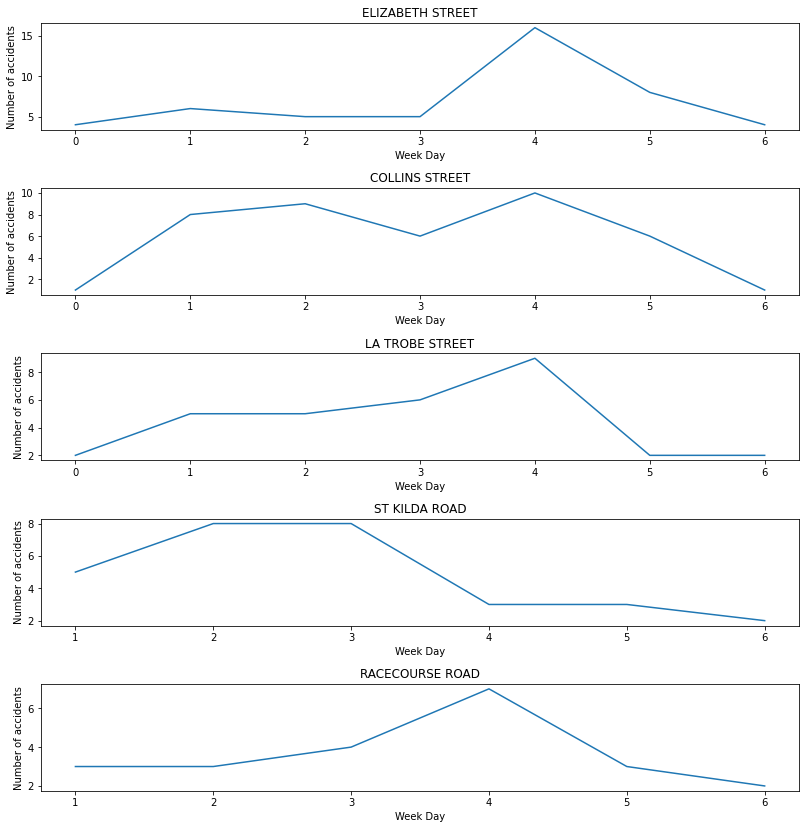

In [10]:
print(wrk_accident_bicyclists_roadsgrp)
fig, ax = plt.subplots(5, figsize=(12,12))
fig.tight_layout(pad=3.75)
plt.setp(ax[:], xlabel='Week Day')
plt.setp(ax[:], ylabel='Number of accidents')

ax[0].title.set_text('ELIZABETH STREET')
ax[1].title.set_text('COLLINS STREET')
ax[2].title.set_text('LA TROBE STREET')
ax[3].title.set_text('ST KILDA ROAD')
ax[4].title.set_text('RACECOURSE ROAD')

ax[0].plot(wrk_accident_bicyclists[wrk_accident_bicyclists['CATAccidentRoadGroup'] == 'ELIZABETH STREET'].groupby('NUMDayOfWeek')['KEYAccidentNumber'].count())
ax[1].plot(wrk_accident_bicyclists[wrk_accident_bicyclists['CATAccidentRoadGroup'] == 'COLLINS STREET'].groupby('NUMDayOfWeek')['KEYAccidentNumber'].count())
ax[2].plot(wrk_accident_bicyclists[wrk_accident_bicyclists['CATAccidentRoadGroup'] == 'LA TROBE STREET'].groupby('NUMDayOfWeek')['KEYAccidentNumber'].count())
ax[3].plot(wrk_accident_bicyclists[wrk_accident_bicyclists['CATAccidentRoadGroup'] == 'ST KILDA ROAD'].groupby('NUMDayOfWeek')['KEYAccidentNumber'].count())
ax[4].plot(wrk_accident_bicyclists[wrk_accident_bicyclists['CATAccidentRoadGroup'] == 'RACECOURSE ROAD'].groupby('NUMDayOfWeek')['KEYAccidentNumber'].count())

The timeline charts use a numerical representation for days of the week, with zero (0) representing Sunday, one (1) representing Monday and so forth.

The number of accidents for each street appear to have a peak around Wednesdays and Thursdays with a decrease at the end of the week.

A curious observation here is, St Kilda Road and Racecourse Roads have no recorded accidents on Sundays (day 0). Could this be reflective of high-usage commute routes for people working in and around the city on weekdays?

<div class="usecase-section-header">Exploring the geography of the bicycle accident event</div>

**Geographical Heat Map**

Let’s get the bicycle accident locations overlaid on a geographical heat map. This will provide a helpful visual starting point to observe the density or 'hot-spots' of accidents and the locations where these occur.

In [11]:
def generateBaseMap(default_location=[-37.81368709240999, 144.95738102347036], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
wrk_accident_bicyclists[['NUMLatitude_node', 'NUMLongitude_node', 'NUMRecordCount']].groupby(['NUMLatitude_node', 'NUMLongitude_node']).sum().sort_values('NUMRecordCount', ascending=False).head(10)
base_map = generateBaseMap()
base_map
m = HeatMap(data=wrk_accident_bicyclists[['NUMLatitude_node', 'NUMLongitude_node', 'NUMRecordCount']].groupby(['NUMLatitude_node','NUMLongitude_node']).sum().reset_index().values.tolist(), radius=7, max_zoom=10).add_to(base_map)
base_map

**Geographical Point Map**

Let's overlay the accident location points and group these by the month the accident occurs in. This is another visualisation which may help with better understanding the timing and geography of bicycle accidents. 

In [12]:
def color(CATInjuryLevelDesc_person):
    if CATInjuryLevelDesc_person == "Not injured":
        col = 'green'
    elif CATInjuryLevelDesc_person == "Other injury":
        col = 'black'
    elif CATInjuryLevelDesc_person == "Serious injury":
        col = 'orange'
    elif CATInjuryLevelDesc_person == "Fatality":
        col = 'red'
    else:
        col='black'
    return col

# Creating a map object using Map() function.
# Location parameter takes latitudes and
# longitudes as starting location.
# (Map will be centered at those co-ordinates)
m = folium.Map(location=[-37.81368709240999, 144.95738102347036],
                zoom_start=13, 
                tiles="cartodbpositron",
                control_scale=True,
                prefer_canvas=True, 
                width=800, 
                height=580) 

#Create a feature group by accident year
January = folium.FeatureGroup(name = 'January')
February = folium.FeatureGroup(name = 'February')
March = folium.FeatureGroup(name = 'March')
April = folium.FeatureGroup(name = 'April')
May = folium.FeatureGroup(name = 'May')
June = folium.FeatureGroup(name = 'June')
July = folium.FeatureGroup(name = 'July')
August = folium.FeatureGroup(name = 'August')
September = folium.FeatureGroup(name = 'September')
October = folium.FeatureGroup(name = 'October')
November = folium.FeatureGroup(name = 'November')
December = folium.FeatureGroup(name = 'December')
#Loop through each row of the working dataset
for i, v in wrk_accident_bicyclists.iterrows():
    
    accmonth = int(v['NUMMonthOfAcc'])    
    popup = """
    Accident ID : <b>%s</b><br>
    Month : <b>%s</b><br>
    Injury : <b>%s</b><br>
    Long : <b>%s</b><br> 
    Lat: <b>%s</b><br>
    """ % (v['KEYAccidentNumber'], v['NUMMonthOfAcc'], 
           v['CATInjuryLevelDesc_person'], v['NUMLongitude_node'], 
           v['NUMLatitude_node'])
    
    # For each accident month in the dataset determine 
    # all marker points and add as separate layers so we can control the display for them
    if accmonth == 1:
        folium.CircleMarker(location = [v['NUMLatitude_node'],v['NUMLongitude_node']],                       
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(January)       
        
    if accmonth == 2:
        folium.CircleMarker(location = [v['NUMLatitude_node'],v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(February)
    
    if accmonth == 3:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                  v['NUMLongitude_node']],                           
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(March)

    if accmonth == 4:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(April)
    
    if accmonth == 5:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(May)

    
    if accmonth == 6:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(June)  

    
    if accmonth == 7:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(July)

    
    if accmonth == 8:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(August)

    
    if accmonth == 9:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(September)

    
    if accmonth == 10:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(October)

    
    if accmonth == 11:
        folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(November)    

    if accmonth == 12:
      folium.CircleMarker(location = [v['NUMLatitude_node'], 
                                 v['NUMLongitude_node']],
                           tooltip = popup,fill=True,color = color(v['CATInjuryLevelDesc_person']),radius=3).add_to(December)                                         
        
#Add the layers to the base map        
January.add_to(m)
February.add_to(m)
March.add_to(m)
April.add_to(m)
May.add_to(m)
June.add_to(m)
July.add_to(m)
August.add_to(m)
September.add_to(m)
October.add_to(m)
November.add_to(m)
December.add_to(m)

#Add the map control
folium.LayerControl(collapsed = False).add_to(m)

#Show the map
m

From this visualisation map, we can see that the number of bicycle accidents tend to increase as the end of the year approaches and start of the calendar year. Starting in October, the closer we get to December, the more accidents appear to be occurring  and this carries over to January.

A hypothesis for this trend could include the occurrence of public holidays and the end of year holiday season. As the end of the year approaches, we are looking at major Australian holidays such as Thanksgiving, Black Friday, Christmas and New Years. These holidays mean that more people are going out to purchase items to prepare for gatherings. They will also be going outside more frequently as well, as most people tend to split up their holiday shopping in multiple trips. Furthermore, because it is summer, it may be more likely for individuals to choose to cycle during this period to for commuting or discovering new places.

**Point pattern analysis using a scatterplot of geographical points**

Showing Density with Hex-binning.

This allows us to visualise a lot more detail on accident 'hot-spots'. It is now more clear that the majority of bicycle accidents relate to much more localized areas.

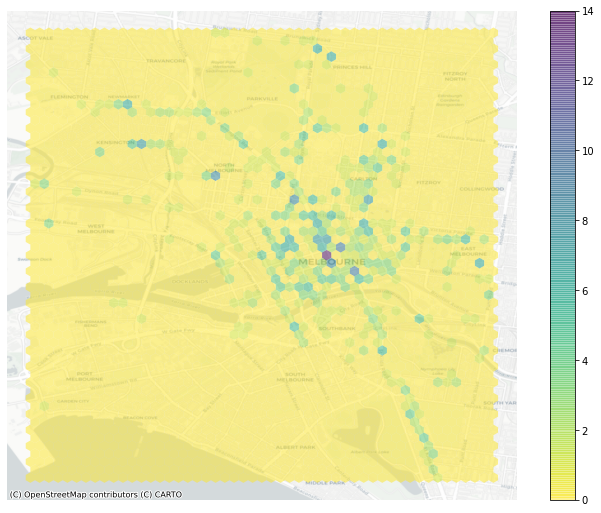

In [13]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    wrk_accident_bicyclists['NUMLongitude_node'], 
    wrk_accident_bicyclists['NUMLatitude_node'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

**Kernel Density Estimation (KDE)**

Instead of overlaying a grid of squares of hexagons and counting how many points fall within each, a Kernel Density Estimation (KDE) lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the Gaussian function, which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point **[1]**. 

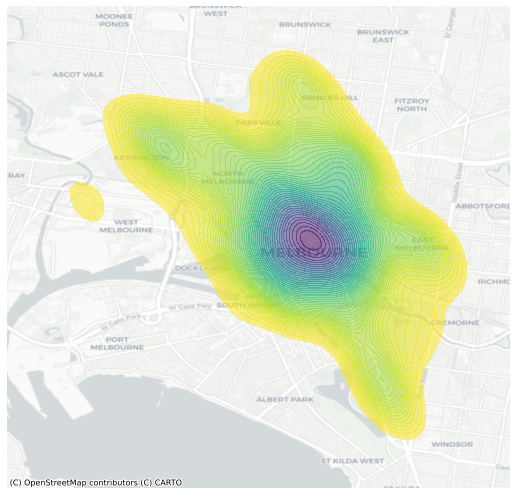

In [14]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(
    wrk_accident_bicyclists['NUMLongitude_node'], 
    wrk_accident_bicyclists['NUMLatitude_node'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

The result is a smoother output that captures the same structure of the hexbin but “eases” the transitions between different areas. This provides a better generalization of the theoretical probability distribution over space. As the area around a point increases, the probability of an event within that area can also be obtained. 

**Centrography**

Centrography is the analysis of centrality in a point pattern. By “centrality,” we mean the general location and dispersion of the pattern. This visualisation will attempt to 'pin-point' a location which represents the centrality of all accidents which have occurred.

In [15]:
mean_center = centrography.mean_center(wrk_accident_bicyclists[['NUMLongitude_node','NUMLatitude_node']])
med_center = centrography.euclidean_median(wrk_accident_bicyclists[['NUMLongitude_node','NUMLatitude_node']])

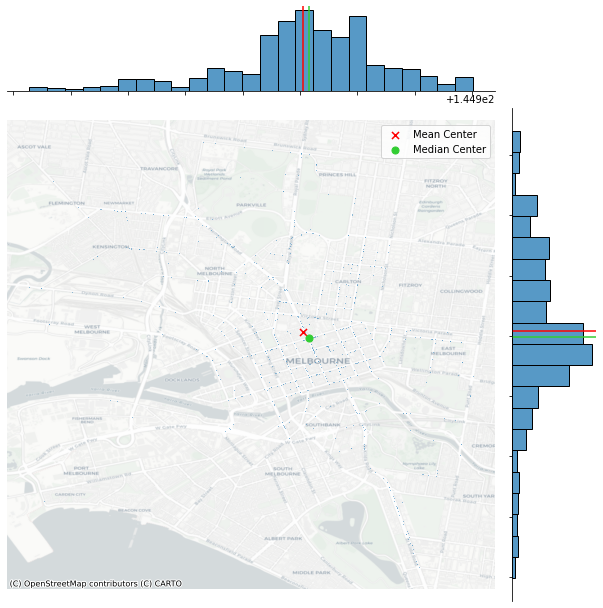

In [16]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x='NUMLongitude_node', y='NUMLatitude_node', data=wrk_accident_bicyclists, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

<div class="usecase-section-header">Exploring the circumstances of the bicycle accident event</div>

**Accident Cirumstances**

This section will inspect the following questions:

What are the bicycle accident circumstances, in what conditions are they occurring? 

Are cyclists colliding with open car doors at an increasing or decreasing rate?

**Weather and Atmospheric Condition Analysis**

   CATAtmosphericConditionDesc_atmosphere CATLightConditionDesc_accident  \
0                                   Clear          Dark No street lights   
1                                   Clear          Dark Street lights on   
2                                   Clear     Dark Street lights unknown   
3                                   Clear                            Day   
4                                   Clear                      Dusk/Dawn   
5                                   Clear                        Unknown   
6                                    Dust                            Day   
7                                     Fog          Dark Street lights on   
8                               Not known          Dark Street lights on   
9                               Not known     Dark Street lights unknown   
10                              Not known                            Day   
11                              Not known                      Dusk/Dawn   
12          

Text(0.5, 1.0, 'Count of Accidents by Atmospheric and Light Conditions')

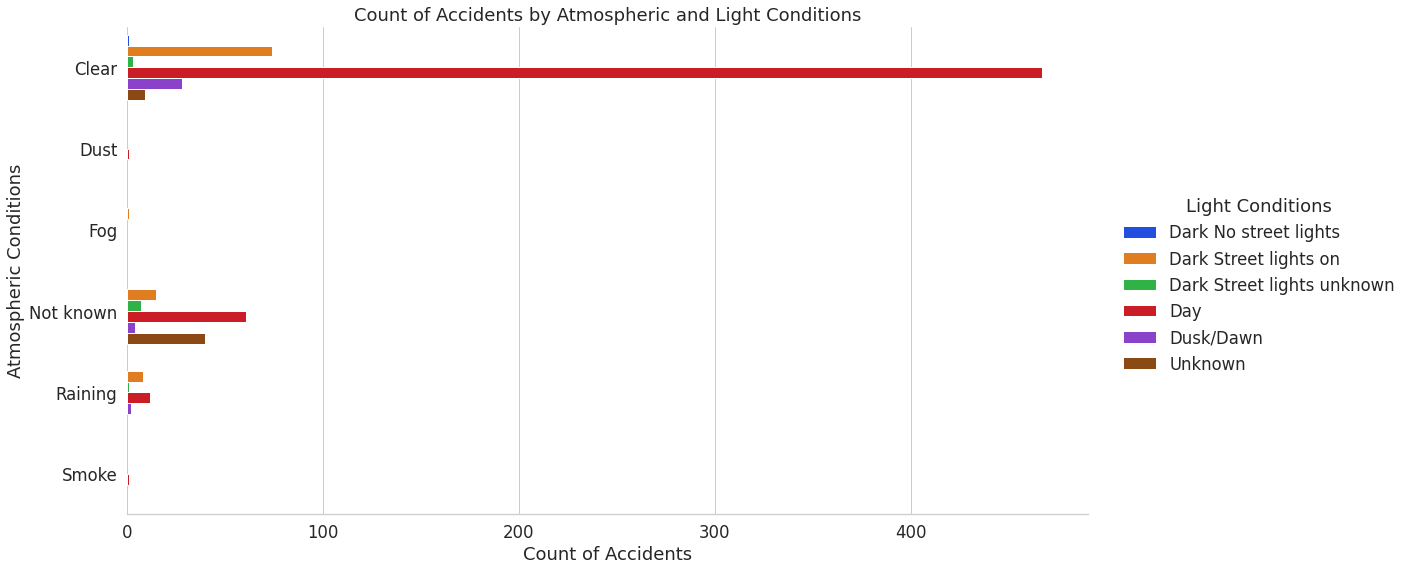

In [23]:
#Create a summary dataset to display results
weather_cond_subset = wrk_accident_bicyclists.groupby(by=['CATAtmosphericConditionDesc_atmosphere', 'CATLightConditionDesc_accident']).agg(NUMRecordCount=('CATLightConditionDesc_accident','count'))
weather_cond_subset.reset_index(drop=False, inplace=True)
weather_cond_subset_pd = pd.DataFrame(weather_cond_subset)
print(weather_cond_subset_pd)

#Plot the summarised data
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

g = sns.catplot(x="NUMRecordCount", y="CATAtmosphericConditionDesc_atmosphere", hue="CATLightConditionDesc_accident", 
            kind="bar",
            palette="colorblind", 
            height=8,
            aspect=2,
            data=weather_cond_subset,
            estimator=sum)
g.despine(left=True)
g.set_axis_labels("Count of Accidents", "Atmospheric Conditions")
g.legend.set_title("Light Conditions")
ax = plt.gca()
ax.set_title("Count of Accidents by Atmospheric and Light Conditions")

We will look at the percentage of accidents per **Light condition** for each weather condition. This will allow for a better comparison between the weather conditions when determining which condition contributed the most to bicycle accidents.

By breaking down the weather conditions based on an accident's severity, we can see that most bicycle accidents are occurring in "Clear" weather conditions during the light conditions of 'Day' and 'Dark Street lights on'. 



In [24]:
#Data Analysis of accident severity with respect to Accident Type
type_acc = wrk_accident_bicyclists['CATAccidentTypeDesc_accident'].value_counts()
print(type_acc)

Collision with vehicle               665
No collision and no object struck     30
Struck Pedestrian                     22
Vehicle overturned (no collision)     12
Fall from or in moving vehicle         3
Other accident                         1
collision with some other object       1
Collision with a fixed object          1
Name: CATAccidentTypeDesc_accident, dtype: Int64


   NUMYearOfAcc       CATAccidentTypeDesc_accident  NUMRecordCount
0          2017             Collision with vehicle             204
1          2017  No collision and no object struck              11
2          2017                  Struck Pedestrian               9
3          2017  Vehicle overturned (no collision)               5
4          2018             Collision with vehicle             188
5          2018     Fall from or in moving vehicle               1
6          2018  No collision and no object struck              11
7          2018                  Struck Pedestrian               6
8          2018  Vehicle overturned (no collision)               3
9          2019             Collision with vehicle             207
10         2019     Fall from or in moving vehicle               2
11         2019  No collision and no object struck               6
12         2019                     Other accident               1
13         2019                  Struck Pedestrian            

Text(0.5, 1.0, 'Count of Bicycle Accident Event Types by Year')

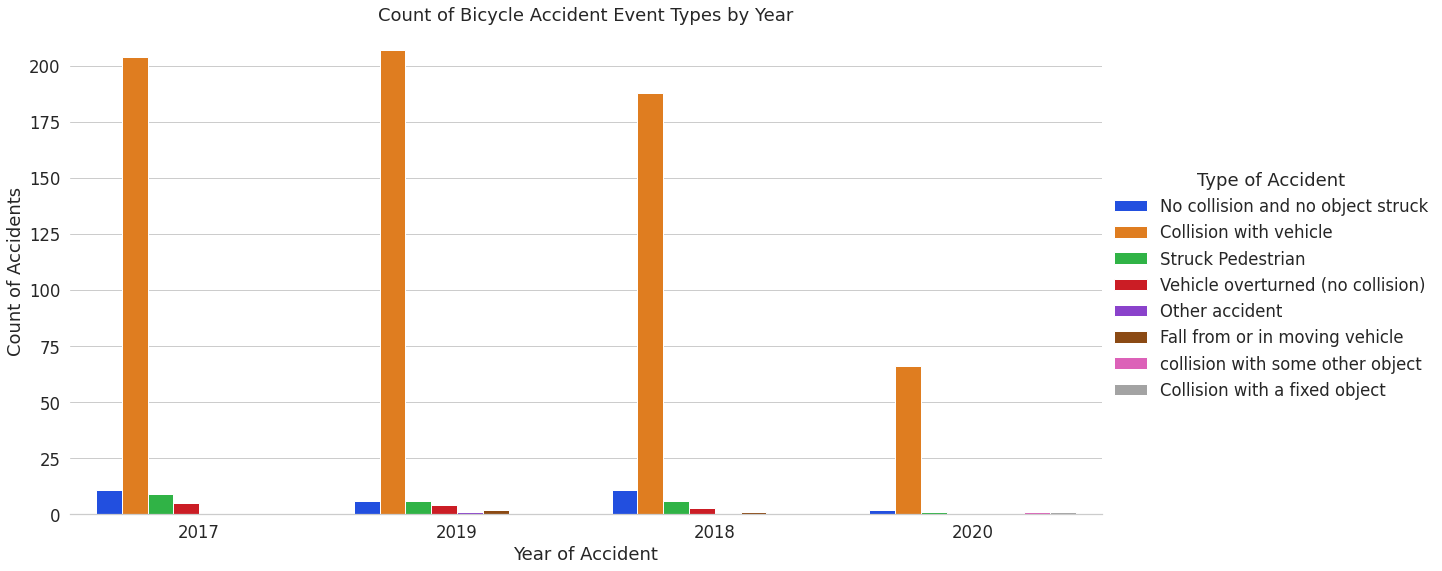

In [25]:
#Create a summary dataset to display results
weather_cond_subset = wrk_accident_bicyclists.groupby(by=['NUMYearOfAcc', 'CATAccidentTypeDesc_accident']).agg(NUMRecordCount=('CATAccidentTypeDesc_accident','count'))
weather_cond_subset.reset_index(drop=False, inplace=True)
weather_cond_subset_pd = pd.DataFrame(weather_cond_subset)
print(weather_cond_subset_pd)

#Plot the summarised data
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.catplot(x="NUMYearOfAcc", y="NUMRecordCount", hue="CATAccidentTypeDesc_accident", 
            kind="bar",
            palette="colorblind", 
            height=8,
            aspect=2,
            data=wrk_accident_bicyclists.sort_values(by='NUMRecordCount'),
            estimator=sum)
g.despine(left=True)
g.set_axis_labels("Year of Accident", "Count of Accidents",)
g.legend.set_title("Type of Accident")
ax = plt.gca()
ax.set_title("Count of Bicycle Accident Event Types by Year")

The preceding graph shows that the type of accident-collision of bicyclists with other vehicles has not decreased, although it has decreased in the year 2020, which is because it only includes data till March 2020. 
Bicycle collisions with other vehicles can vary, for example,

**Dooring accidents** - when a parallel-parked vehicle opens its doors directly in front of a cyclist, when attempting to dodge the door, the bicycle either hits it or is thrown into the path to avoid the car.

**Right Hook Bike Accident-**this occurs when an automobile passes a cyclist on the cyclist's left and the car then makes an urgent right turn, possibly immediately in front of or into the cyclist.

**Left Cross Bike Accident** - occurs when a car coming from the opposite direction of a cyclist turns left in front of the cyclist or into the cyclist.

**Red Light Bike Accident** - occurs when a cyclist comes to a red light and stops to the right of a waiting car and when the light turns green, the motorist may turn right and can hit the cyclist.

**Wrong Way Bike Accident** - occur when a cyclist is riding on the wrong side of the road. A car could pull out from the left and hit the cyclist.



<div class="usecase-section-header">Findings and Opportunities</div>

This analysis has provided a deeper dive into exploring the Melbourne Open Data Bicycle Network dataset and Traffic Accidents (Bicyclists) data.

**We achieved in this analysis:**

- A series of visualisations which illustrate the timing, geography and circumstances of bicycle accidents occurring in Melbourne between the year 2017 and 2020.

**We learned from this analysis:**

- A more refined view of where the accident hotspots are located in Melbourne.
- Most bicycle accidents involve a collision with a motor vehicle.
- Most bicycle accidents occur in clear, daylight conditions.
- The highest frequency of any bicycle accidents to occur are during weekdays and near the peak hours of 8am and 5pm.


**Observations for further opportunities**
There is opportunity for future analyses work to dive deeper into accident time trends and injury severity.

In [1]:
!jupyter nbconvert --to html usecase-bicyclenetworkroadsafety-part2.ipynb

[NbConvertApp] Converting notebook usecase-bicyclenetworkroadsafety-part2.ipynb to html
[NbConvertApp] Writing 3098390 bytes to usecase-bicyclenetworkroadsafety-part2.html
